In [1]:
using PyPlot
using LinearAlgebra
using Test
using Random
using GaussQuadrature
using Statistics
using JLD
import Seaborn; const sn = Seaborn

const exact = 5*pi*pi/(16*16);

# Tests

In [15]:
function test_legendre()
    """ A unit test for validating the weights and abcissas generated by the GaussQuadrature module """
    N = 5
    
    x_leg, w_leg = legendre(N)
    w_leg = w_leg[1:3]
    
    w_leg_exact = [(322 - 13*sqrt(70))/900, (322 + 13*sqrt(70))/900, 128/225]
    x_leg_exact = [-1/3*sqrt(5 + 2*sqrt(10/7)), -1/3*sqrt(5 - 2*sqrt(10/7)), 0 , 1/3*sqrt(5 - 2*sqrt(10/7)), 1/3*sqrt(5 + 2*sqrt(10/7))]
    
    @testset begin
        @test abs(w_leg[1] .- w_leg_exact[1]) < 1e-12
        @test abs(w_leg[2] .- w_leg_exact[2]) < 1e-12
        @test abs(w_leg[3] .- w_leg_exact[3]) < 1e-12
        
        @test abs(x_leg[1] .- x_leg_exact[1]) < 1e-12
        @test abs(x_leg[2] .- x_leg_exact[2]) < 1e-12
        @test abs(x_leg[3] .- x_leg_exact[3]) < 1e-12
    end
    
    println("Legendre module test successful")
end
    

[0.295647, -0.723319, -0.0011584, -8.68493e-7, -2.94073e-9]
[0.521756, 0.398667, 0.0759424, 0.00361176, 2.337e-5]


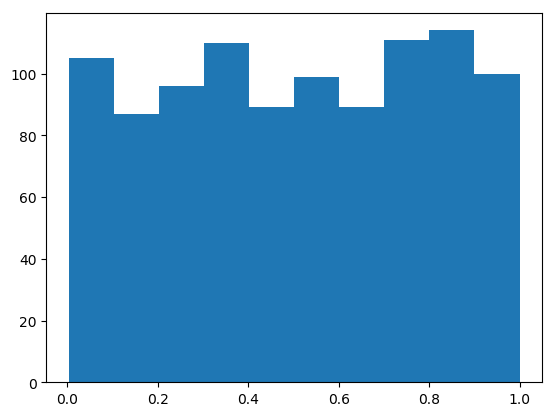

In [3]:
plt.hist(rand(1000));

# a) Gauss-Legendre Quadrature

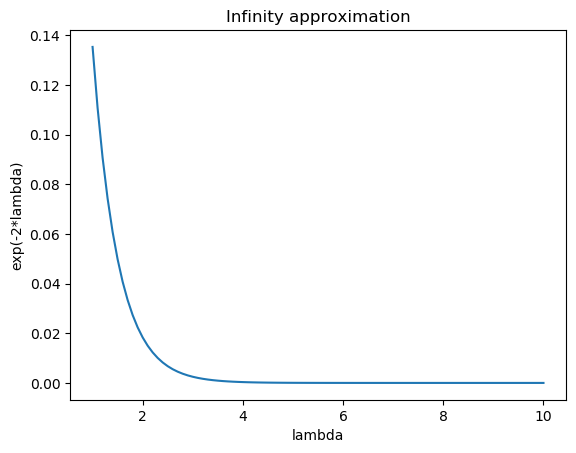

In [35]:
"""Find the best approximation to infinity by 
finding where exp(-alpha*x) is close to zero"""

function find_lambda(lambda)
    alpha = 2
    
    return exp(-alpha*lambda)
end

lambdas = 1:0.1:10
y =  map(find_lambda, lambdas)

plot(lambdas, y)
xlabel("lambda")
ylabel("exp(-2*lambda)")
title("Infinity approximation")
savefig("lambda.png",dpi=500)

In [2]:
function foo(x1, y1, z1, x2, y2, z2)
    """
    Function to integrate, in this case the quantum mechanical
    expectation value of the correlation energy between two electrons
    which repel each other via the classical Coulomb interaction

    """
    alpha = 2.
    
    norm1 = sqrt(x1*x1 + y1*y1 + z1*z1)
    norm2 = sqrt(x2*x2 + y2*y2 + z2*z2)
    
    xdiff = x1 - x2
    ydiff = y1 - y2
    zdiff = z1 - z2
    
    frac_term = sqrt(xdiff*xdiff + ydiff*ydiff + zdiff*zdiff)

    
    if frac_term < 1e-8
        result = 0.
    else
        result = exp(-2.0*alpha*(norm1 + norm2))/frac_term  
    end
    
    return result
end

function change_limits(a, b, x::Array)
    """ Returns the input array x with new 
        limits such that x in [a, b] """
    
    return 0.5 .* (x .+ 1) .* (b - a) .+ a
end

change_limits (generic function with 1 method)

In [43]:
function gauss_legendre(a::Float64, b::Float64, N::Int64)
    """ Perform a brute force Gauss-Legendre quatrature
    numerical integration
    a: -infty approx
    b: +infty approx
    N: no. of points
    """
    
    x_, w = legendre(N) # nodes and weights
    
    # map to [-a, b]
    x = change_limits(a, b, x_)

    
    summ = 0.0
    
    for i = 1:N, j = 1:N, k = 1:N, l = 1:N, m = 1:N, n = 1:N
        summ += w[i]*w[j]*w[k]*w[l]*w[m]*w[n]*
        foo(x[i], x[j], x[k], x[l], x[m], x[n])
    end
                        
    
    summ *= ((b - a)*0.5)^6 # multiply result by the changed limits
     
    return summ, abs(summ - exact)/summ
end
       

gauss_legendre (generic function with 1 method)

In [86]:
ns = 2:30 # n-values
lambdas = 1.:6. # approximations to infinity

error_leg = zeros(length(ns), length(lambdas))
result_leg = zeros(length(ns), length(lambdas))
time = zeros(length(ns))
timeavg = 0.
for (idx, n) in enumerate(ns)
    
    for (jdx, l) in enumerate(lambdas)
        result = @timed gauss_legendre(-l, l, n)
        error_leg[idx, jdx] = result[1][2]
        timeavg += result[2]
        result_leg[idx, jdx] = result[1][1]
    end
    time[idx] = timeavg/length(lambdas)
    println("n = $(n) finished")
end

n = 2 finished
n = 3 finished
n = 4 finished
n = 5 finished
n = 6 finished
n = 7 finished
n = 8 finished
n = 9 finished
n = 10 finished
n = 11 finished
n = 12 finished
n = 13 finished
n = 14 finished
n = 15 finished
n = 16 finished
n = 17 finished
n = 18 finished
n = 19 finished
n = 20 finished
n = 21 finished
n = 22 finished
n = 23 finished
n = 24 finished
n = 25 finished
n = 26 finished
n = 27 finished
n = 28 finished
n = 29 finished
n = 30 finished


In [65]:
# making a heatmap of odd polynomial degrees

fig = plt.figure()
ax = sn.heatmap(map(log10, error_leg[2:2:29,:]), annot=true, 
           yticklabels=ns[2:2:29], xticklabels=lambdas)
ax.set_xlabel("lambda"); ax.set_ylabel("N")
ax.set_ylim(0, 14)
ax.collections[1].colorbar.set_label("log10 error")
title("Error from Legendre polynomials")
#savefig("legendre_heatmap.png", dpi=500)


UndefVarError: UndefVarError: lambdas not defined

# b) Improved Gauss-Quadrature


In [3]:
@everywhere function foo_spherical(r1::Float64, r2::Float64, theta1::Float64, 
                                   theta2::Float64, phi1::Float64, phi2::Float64)
    
    """Function in spherical coordinates"""
    
    alpha = 2.
    
    cosbeta = cos(theta1)*cos(theta2) + sin(theta1)*sin(theta2)*cos(phi1 - phi2)
    
    dist = r1*r1 + r2*r2 - 2*r1*r2*cosbeta
    
    if dist < 0 || dist < 1e-8
        result = 0.
    else
        result = sin(theta1)*sin(theta2)*exp(-3*(r1 + r2)) / sqrt(dist)
    end
        
    return result
    
end



function gauss_laguerre(N::Int64)
    """ Quadrature with Laguerre polynomials """
    
    rho, w_rho = laguerre(N, 2.0) # nodes and weights for rho
    
    phitheta, w_phitheta = legendre(N) # nodes and weights for phi and theta
    
    # change limits
    phi = change_limits(0, 2*pi, phitheta) 
    theta = change_limits(0, pi, phitheta)

    summ = 0
    for i = 1:N, j = 1:N, k = 1:N, l = 1:N, m = 1:N, n = 1:N
        summ += w_rho[i]*w_rho[j]*w_phitheta[k]*w_phitheta[l]*w_phitheta[m]*w_phitheta[n]*
                foo_spherical(rho[i], rho[j], theta[k], theta[l], phi[m], phi[n])

    end
    
    newlims = 0.25*pi^4
    return summ*newlims
end

LoadError: UndefVarError: @everywhere not defined

In [74]:
ns = 2:30 # n-values
error_lag = zeros(length(ns))
result_lag = zeros(length(ns))
time_lag = zeros(length(ns))
timeavg = 0.
for (idx, n) in enumerate(ns)
    
    for j = 1:5
        result = @timed gauss_laguerre(n)
        timeavg += result[2]
        
        if j == 5 
            error_lag[idx] = abs(result[1] - exact)/result[1] 
            result_lag[idx] = result[1]
        end
    end
    time_lag[idx] = timeavg/5
    println("n = $(n) finished")
end

n = 2 finished
n = 3 finished
n = 4 finished
n = 5 finished
n = 6 finished
n = 7 finished
n = 8 finished
n = 9 finished
n = 10 finished
n = 11 finished
n = 12 finished
n = 13 finished
n = 14 finished
n = 15 finished
n = 16 finished
n = 17 finished
n = 18 finished
n = 19 finished
n = 20 finished
n = 21 finished
n = 22 finished
n = 23 finished
n = 24 finished
n = 25 finished
n = 26 finished
n = 27 finished
n = 28 finished
n = 29 finished
n = 30 finished


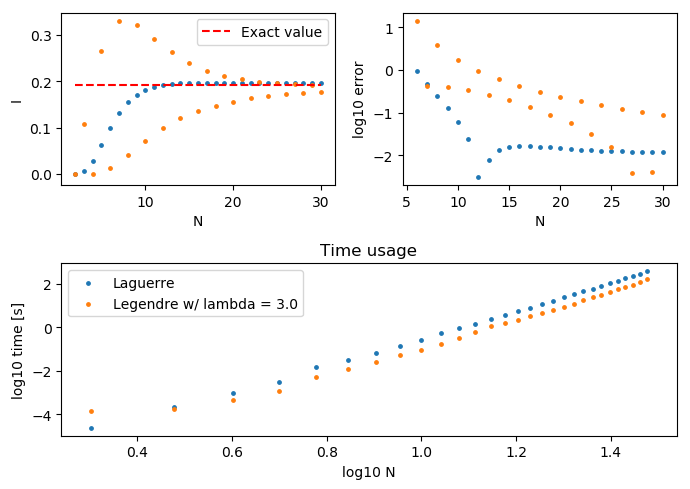

0.1431506786748577
1.9562827485061676


In [26]:
""" Plotting """

ns = 2:30

error_lag, result_lag, time_lag = load("laguerre.jld", "error", "result", "time")
error_leg, result_leg, time_leg = load("legendre.jld", "error", "result", "time")

plt.figure(figsize=(7,5))

ax1 = subplot(221)
ax1.scatter(ns, result_lag, s=6)
ax1.scatter(ns, result_leg[:,3], s=6)
ax1.plot([ns[1], ns[end]], [exact, exact], color="r", linewidth=1.5, label="Exact value", "--")
ax1.set_xlabel("N"); ax1.set_ylabel("I")
ax1.legend()


ax2 = subplot(222)

ax2.scatter(ns[5:end], log10.(error_lag[5:end]), s=6)
ax2.scatter(ns[5:end], log10.(error_leg[5:end,3]), s=6)
ax2.set_ylabel("log10 error"); ax2.set_xlabel("N")

ax3 = subplot(212)

ax3.scatter(log10.(ns), log10.(time_lag), label="Laguerre", s=6)
ax3.scatter(log10.(ns), log10.(time_leg), label="Legendre w/ lambda = 3.0", s=6)
ax3.set_title("Time usage")
ax3.set_xlabel("log10 N"); ax3.set_ylabel("log10 time [s]")
plt.tight_layout()

plt.legend()
#plt.savefig("laguerre_legendre.png", dpi=500)

println(log10.(time_lag[12]))
println(log10.(time_leg[27]))

# c) Monte Carlo Integration

In [6]:
function bruteforce_montecarlo(lambda::Float64, N::Int64)
    """ MonteCarlo integration with uniform sampling """
    
    summ = 0.
    summ2 = 0.
    t = @elapsed begin
        for i = 1:N
            
            x = -lambda .+ 2*lambda .* rand(6) # generate 6 uniform random x-values in the interval x in [-lambda, lambda]

            y = foo(x[1], x[2], x[3], x[4], x[5], x[6]) # evaluate the function at the random x-values
            
            summ += y # sum the result
            summ2 += y*y
        end
    end
  
    # calculate the mean and multiply by the changed limits
    summ /= N
    summ2 /= N
    area = (2*lambda)^6
    
    int_est = summ*area
    std_dev = area*sqrt((summ2 - summ^2)/N)
    return summ*area, std_dev, t
end

bruteforce_montecarlo (generic function with 1 method)

# d) Improved Monte Carlo Integration

In [9]:
function foo_spherical_MC(r1::Float64, r2::Float64, theta1::Float64, 
                                   theta2::Float64, phi1::Float64, phi2::Float64)
    
    """Function in spherical coordinates with importance sampling with """
    
    alpha = 2.
    
    cosbeta = cos(theta1)*cos(theta2) + sin(theta1)*sin(theta2)*cos(phi1 - phi2)
    
    dist = r1*r1 + r2*r2 - 2*r1*r2*cosbeta
    
    if dist < 0 || dist < 1e-12
        result = 0.
    else
        result = r1*r1*r2*r2*sin(theta1)*sin(theta2)*exp(-4*(r1 + r2)) / sqrt(dist)
    end
        
    return result
    
end

function improved_montecarlo(N::Int64)
    """ Monte Carlo integration using exponential PDF and spherical coordinates """
    
    PDF_exp(x::Float64) = -0.25*log(1 - x) # new x values from exp PDF
    PDF(y::Float64) = 4*exp(-4*y) # exponential propability distribution function
    
    phimax = 2*pi
    
    thetamax = pi
    summ1::Float64 = 0.
    summ2::Float64 = 0.
    
    t = @elapsed begin
        for i = 1:N
            rands = rand(Float64, 6) # random numbers in [0, 1]
            
            r1, r2 = map(PDF_exp, rands[1:2])     # new r-values
            theta1, theta2 = thetamax .* rands[3:4]
            phi1, phi2, = phimax .* rands[5:6]

            temp = foo_spherical_MC(r1, r2, theta1, theta2, phi1, phi2)/(PDF(r1)*PDF(r2))
            summ1 += temp 
            summ2 += temp*temp
            
        end # end for
    end

    summ1 /= N
    summ2 /= N
    
    jacobian = 4*pi^4

    std_dev = sqrt((summ2 - summ1*summ1)/N)*jacobian
    return summ1*jacobian, std_dev, t
    
end


improved_montecarlo (generic function with 1 method)

In [10]:
summ_bf = zeros(100)
summ_imp = zeros(100)

for i = 1:100
    summ_bf[i] = bruteforce_montecarlo(3.0, 10000000)[1]
    summ_imp[i] = improved_montecarlo(10000000)[1]
end

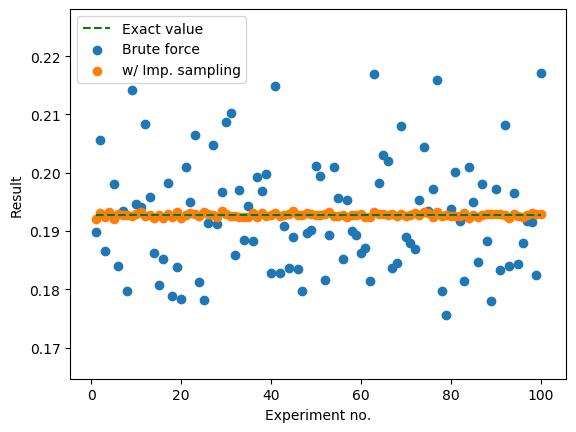

In [16]:
plt.scatter(1:100, summ_bf, label="Brute force")
plt.scatter(1:100, summ_imp, label="w/ Imp. sampling")
plt.plot([1, 100], [exact, exact], color="g", linewidth=1.5, label="Exact value", "--")
plt.xlabel("Experiment no.")
plt.ylabel("Result")
plt.legend()
plt.savefig("bf_v_impsamp.png", dpi=500)

In [33]:
function study_montecarlo()
    """ Perform multiple montecarlo experiments and save the results """
    
    ns_MC = [10^i for i = 1:8] # number of Monte Carlo iterations
    m = 100 # number of iterations per n

    error_brute = zeros(length(ns_MC), m)
    error_impsamp = copy(error_brute)

    time_brute = zeros(length(ns_MC))
    time_impsamp = copy(time_brute)

    stddev_brute = copy(error_brute)
    stddev_impsamp = copy(stddev_brute)

    for i = 1:length(ns_MC)
        for j = 1:m
            result_brute = bruteforce_montecarlo(2.0, ns_MC[i])
            result_impsamp = improved_montecarlo(ns_MC[i])

            error_brute[i, j] = abs(result_brute[1] - exact)/result_brute[1]
            error_impsamp[i, j] = abs(result_impsamp[1] - exact)/result_impsamp[1]

            stddev_brute[i, j] = result_brute[2]
            stddev_impsamp[i, j] = result_impsamp[2]

            time_brute[i] += result_brute[3]
            time_impsamp[i] += result_impsamp[3]
        end # end j

        # get mean of times
        time_brute[i] /= m 
        time_impsamp[i] /= m    

    end # end i
    
    save("error_brute.jld", "error_brute", error_brute)
    save("error_impsamp.jld", "error_impsamp", error_impsamp)
    save("time_brute.jld", "time_brute", time_brute)
    save("time_impsamp.jld", "time_impsamp", time_impsamp)
    save("stddev_brute.jld", "stddev_brute", stddev_brute)
    save("stddev_impsamp.jld", "stddev_impsamp", stddev_impsamp)
end

# study_montecarlo() # executed in 3h 27m 32s,


study_montecarlo (generic function with 1 method)

In [72]:
error_brute = load("./data/error_brute.jld", "error_brute")
error_impsamp = load("./data/error_impsamp.jld", "error_impsamp")

time_brute = load("./data/time_brute.jld", "time_brute")
time_impsamp = load("./data/time_impsamp.jld", "time_impsamp")

stddev_brute = load("./data/stddev_brute.jld", "stddev_brute")
stddev_impsamp = load("./data/stddev_impsamp.jld", "stddev_impsamp");

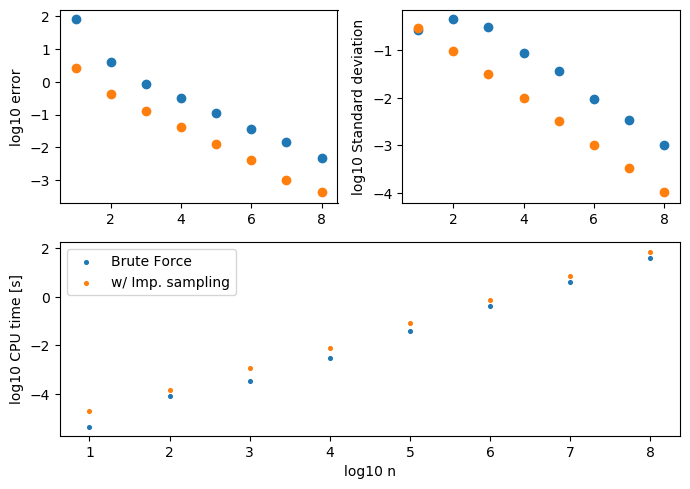

In [87]:
""" Plotting Monte Carlo results """
# mean results of the bruteforce- and importance sampling methods

log10ns = 1:8
means_brute = [mean(error_brute[i,:]) for i in log10ns]
means_impsamp = [mean(error_impsamp[i,:]) for i in log10ns]

# means of the standard deviations of both methods


means_std_brute = [sqrt(mean(stddev_brute[i,:] .^2)) for i in log10ns]
means_std_impsamp = [sqrt(mean(stddev_impsamp[i,:] .^2)) for i in log10ns]

"""fig, (ax1, ax2) = subplots(1, 2, figsize=(10, 4), sharex=true)
ax1.scatter(1:8, map(log10, means_brute))
ax1.scatter(1:8, map(log10, means_impsamp))
ax1.set_ylabel("log10 error")
ax1.set_xlabel("log10 N")


ax2.scatter(1:8, map(log10, means_std_brute), label="Brute-force")
ax2.scatter(1:8, map(log10, means_std_impsamp), label="w/ imp. sampling")
ax2.set_xlabel("log10 N")
ax2.set_ylabel("log10 Standard deviation")

suptitle("Mean error and std. deviation of Monte Carlo integration over 100 iterations")
fig.legend()
#fig.savefig("montecarlo_error_stddev.png", dpi=500)"""


plt.figure(figsize=(7,5))

ax1 = subplot(221)
ax1.scatter(log10ns, map(log10, means_brute))
ax1.scatter(log10ns, map(log10, means_impsamp))
ax1.set_ylabel("log10 error")


ax2 = subplot(222)

ax2.scatter(log10ns, map(log10, means_std_brute), label="Brute-force")
ax2.scatter(log10ns, map(log10, means_std_impsamp), label="w/ imp. sampling")
ax2.set_ylabel("log10 Standard deviation")

ax3 = subplot(212)

ax3.scatter(log10ns, log10.(time_brute), s=7, label="Brute Force")
ax3.scatter(log10ns, log10.(time_impsamp), s=7, label="w/ Imp. sampling")
ax3.set_xlabel("log10 n")
ax3.set_ylabel("log10 CPU time [s]")
ax3.legend()
plt.tight_layout()
plt.savefig("montecarlo.png", dpi=500)


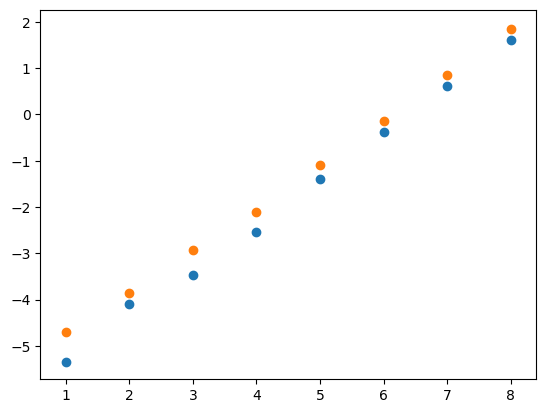

PyObject <matplotlib.collections.PathCollection object at 0x0000000046F66780>

In [76]:
plt.scatter(1:8, log10.(time_brute))
plt.scatter(1:8, log10.(time_impsamp))

# Parallelization

In [3]:
""" Importing results from C experiments """

t_parallel = zeros(6, 100)
t_serial = zeros(6, 100)

error_serial = zeros(6, 100)
error_parallel = zeros(6, 100)

stddev_parallel = zeros(6, 100)
stddev_serial = zeros(6, 100)

for i = 1:6
    n = string(10^(i+2))

    open("serial_n=$(n).txt") do f
        readline(f)

        j = 1
        for ln in eachline(f)
            words = split(ln)
            t_serial[i, j] = parse(Float64, words[3])
            error_serial[i, j] = parse(Float64, words[5])
            stddev_serial[i, j] = parse(Float64, words[7])
            
        end
        
    end

    open("parallel_n=$(n).txt") do f
        time = 0.
        error = 0.
        stddev = 0.
        readline(f)

        j = 1
        for ln in eachline(f)
            words = split(ln)
            t_parallel[i, j] = parse(Float64, words[3])
            error_parallel[i, j] = parse(Float64, words[5])
            stddev_parallel[i, j] = parse(Float64, words[7])
            
        end
    end
    
end # end i


In [64]:
t_serial = [mean(t_serial[i,:]) for i = 1:6]
t_parallel = [mean(t_parallel[i,:]) for i = 1:6]



t_speedup = t_serial ./ t_parallel
t_julia = time_impsamp[3:end]

n_values = 3:8

plt.figure()
plt.scatter(n_values, map(log10, t_parallel), label="Parallel C (MPI)")
plt.scatter(n_values, map(log10, t_serial), label="Serial C")
plt.scatter(n_values, map(log10, t_julia), label="Serial Julia")
plt.legend()
#plt.xticks([3, 4, 5, 6, 7, 8])
plt.xlabel("log10 n"); plt.ylabel("log10 CPU time")


"""plt.figure()
plt.scatter(n_values, error_parallel, label="Parallel error")
plt.scatter(n_values, error_serial, label="Serial error")
plt.scatter(n_values, map(log10,means_impsamp[1:end-1]), label="Julia error")
plt.legend()"""

UndefVarError: UndefVarError: t_serial not defined

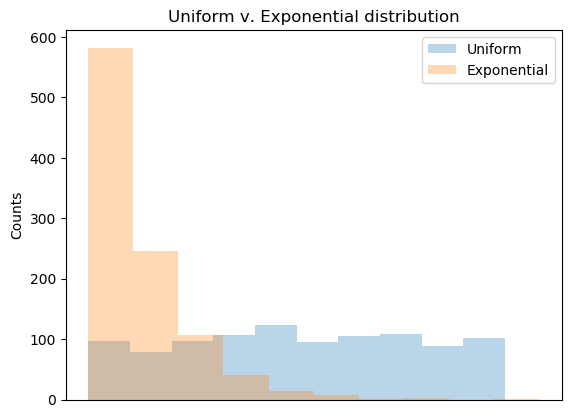

PyObject <matplotlib.legend.Legend object at 0x00000000461F4A58>

In [63]:
plt.figure()
sn.hist(rand(1000), alpha=.3, label="Uniform")
sn.hist(randexp(1000) ./ 8, alpha=.3, label="Exponential")
plt.xticks(()); plt.ylabel("Counts")
plt.title("Uniform v. Exponential distribution")
plt.savefig("uni_v_expo.png", dpi=500)
plt.legend()